**Dataset: ICCAD-2012**

You can download the ICCAD-2012 dataset as a ZIP file from the following link: [ICCAD-2012](https://drive.google.com/file/d/1lawhHhiJklrrgr2SlO172n1X69XRnsM1/view?usp=share_link) Download.

Please note that the file is large (approximately 136 MB), so there is no need to extract it after downloading. Simply download the ZIP file and upload it directly to your Google Drive in the location where you intend to access it later.

**Example:**
In my Google Drive, I have a folder named Coin-3D, which contains another folder called Lithograph. I uploaded the ZIP file directly into the Lithograph folder.



How the ICCAD Dataset looks like?
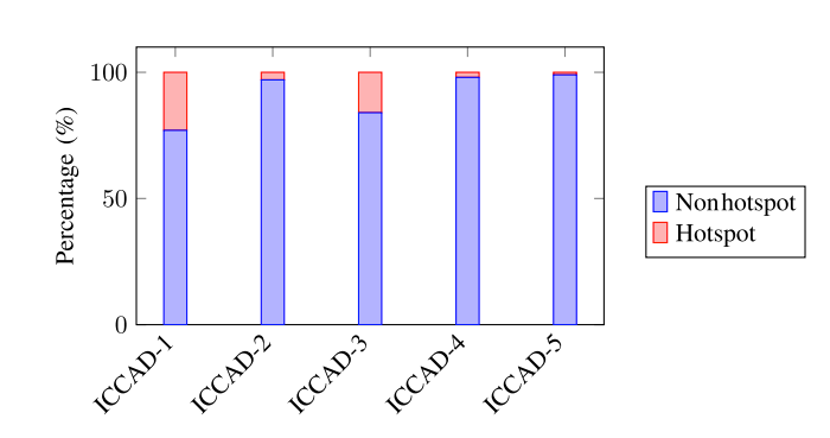



**Google Drive Access**

To access files stored in your Google Drive from this notebook, you first need to mount your Google Drive. This connects your Drive to the Colab environment so you can read or write files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x /content/drive/MyDrive/Coin-3D/Lithography/iccad_official.rar -d /content/


Streaming output truncated to the last 5000 lines.
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png3.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png4.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png6.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png7.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png8.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png9.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png1.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png2.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png3.png      97%  OK 
Extracting  /content/iccad-official/icca

**Extracts a .rar file from  Google Drive**

This command extracts a .rar file from your Google Drive into the Colab working directory.
!unrar x tells Colab to use the unrar tool to extract the file.
The path after it is the location of the .rar file in your Drive, and -d /content/ sets the destination folder for the extracted contents.

**Import**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm



**2. Custom CNN Model**

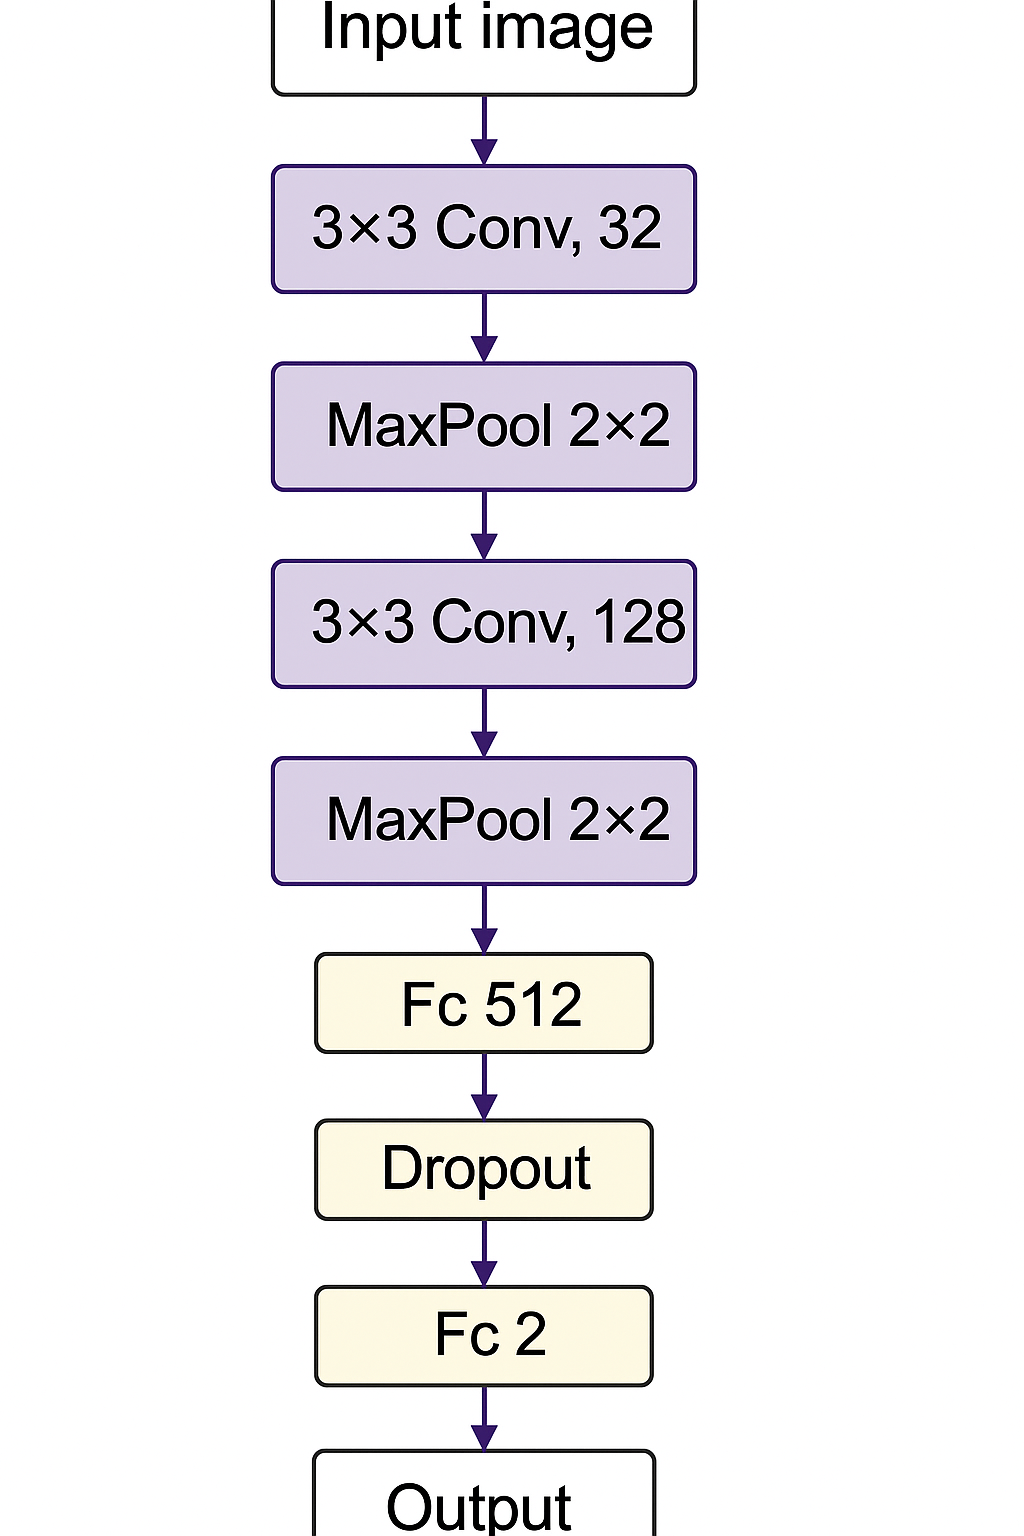



This code defines a custom convolutional neural network (CNN) class called HotspotCNN for binary classification tasks, such as detecting lithographic hotspots. The network processes input images with three convolutional layers (with increasing filter sizes: 32, 64, 128), each followed by a ReLU activation and max-pooling to reduce spatial dimensions. After flattening the extracted features, it passes them through a fully connected layer with 512 units, applies dropout for regularization, and finally outputs predictions through a second fully connected layer with 2 outputs representing the class scores. This architecture expects input images of size 224×224 pixels.

In [ ]:
class HotspotCNN(nn.Module):
    def __init__(self):
        super(HotspotCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # for 224x224 input
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
#Keras
from tensorflow.keras import layers, models

def HotspotCNN(input_shape=(224, 224, 3), num_classes=2):
    model = models.Sequential()

    # First Conv + Pool
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Conv + Pool
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Conv + Pool
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and Fully Connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  # use softmax for multi-class classification

    return model

# Example usage:
model = HotspotCNN()
model.summary()


**Step. 3: Multi-ICCAD Dataset Loader**  

In [ ]:
class MultiICCADLayoutDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.transform = transform
        self.samples = []

        for i in range(1, 6):  # ICCAD1 to ICCAD5
            iccad_path = os.path.join(base_dir, f"iccad{i}", "train")
            class_map = {"train_nhs": 0, "train_hs": 1}
            for class_name, label in class_map.items():
                class_dir = os.path.join(iccad_path, class_name)
                if not os.path.exists(class_dir): continue
                for file in os.listdir(class_dir):
                    if file.lower().endswith((".png", ".jpg", ".jpeg")):
                        self.samples.append((os.path.join(class_dir, file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


**Step 4: Data Preparation**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = MultiICCADLayoutDataset("/content/iccad-official", transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


**Step 5: Model Initialization**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HotspotCNN().to(device)

**Step 6: Training Loop with Accuracy per Epoch**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(15):  # Adjust as needed
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {epoch_acc:.4f}")


100%|██████████| 469/469 [04:28<00:00,  1.75it/s]


Epoch 1, Loss: 41.7558, Accuracy: 0.9717


100%|██████████| 469/469 [04:19<00:00,  1.80it/s]


Epoch 2, Loss: 17.2815, Accuracy: 0.9865


100%|██████████| 469/469 [04:17<00:00,  1.82it/s]


Epoch 3, Loss: 10.9728, Accuracy: 0.9915


100%|██████████| 469/469 [04:17<00:00,  1.82it/s]


Epoch 4, Loss: 7.5475, Accuracy: 0.9943


100%|██████████| 469/469 [04:18<00:00,  1.82it/s]


Epoch 5, Loss: 6.3870, Accuracy: 0.9953


100%|██████████| 469/469 [04:18<00:00,  1.81it/s]


Epoch 6, Loss: 4.5387, Accuracy: 0.9969


100%|██████████| 469/469 [04:18<00:00,  1.82it/s]


Epoch 7, Loss: 3.3305, Accuracy: 0.9980


100%|██████████| 469/469 [04:19<00:00,  1.81it/s]


Epoch 8, Loss: 2.3661, Accuracy: 0.9987


100%|██████████| 469/469 [04:18<00:00,  1.81it/s]


Epoch 9, Loss: 2.4805, Accuracy: 0.9985


100%|██████████| 469/469 [04:18<00:00,  1.82it/s]


Epoch 10, Loss: 1.8703, Accuracy: 0.9985


100%|██████████| 469/469 [04:20<00:00,  1.80it/s]


Epoch 11, Loss: 1.8167, Accuracy: 0.9985


100%|██████████| 469/469 [04:20<00:00,  1.80it/s]


Epoch 12, Loss: 0.9849, Accuracy: 0.9993


100%|██████████| 469/469 [04:17<00:00,  1.82it/s]


Epoch 13, Loss: 0.7454, Accuracy: 0.9995


100%|██████████| 469/469 [04:18<00:00,  1.82it/s]


Epoch 14, Loss: 0.6006, Accuracy: 0.9995


100%|██████████| 469/469 [04:18<00:00,  1.82it/s]

Epoch 15, Loss: 0.8045, Accuracy: 0.9993


**7. Final Evaluation (Precision, Recall, F1)**

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print("Evaluation on Test Set:")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")


Evaluation on Test Set:
Accuracy:  0.9965
Precision: 0.9600
Recall:    0.9877
F1 Score:  0.9736
